# Image Caption Generator

## Introduction

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order.

## Dataset

We will be using the Flickr8k Dataset for our project.

It contains around 8091 images and 5 captions for each image (5 * 8091 = 40455 captions)

Dataset Source: KAGGLE LINK https://www.kaggle.com/shadabhussain/flickr8k

## Model Evaluation matrix

BLEU (Bilingual Evaluation Understudy)

BLEU is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

*The Python Natural Language Toolkit library, or NLTK, provides an implementation of the BLEU score that you can use to evaluate your generated text against a reference.*

### Importing necessary libraries

In [1]:
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

# Configuring gpu for notebook
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

Using TensorFlow backend.


python 3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
keras version 2.2.4
tensorflow version 2.3.0


### Downloading and importing dataset in the notebook

In [2]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "C:/Users/aksha/Desktop/image-caption/Flickr8k_Dataset/Flicker8k_Dataset"
## The location of the caption file
dir_Flickr_text = "C:/Users/aksha/Desktop/image-caption/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


## Preliminary Analysis

#### Importing Caption data

Load the text data and save it into a panda dataframe df_txt.

In [3]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")

# Counting number of captions for each image using counter
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [4]:
df_txt[:6]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting


### Example pictures with captions

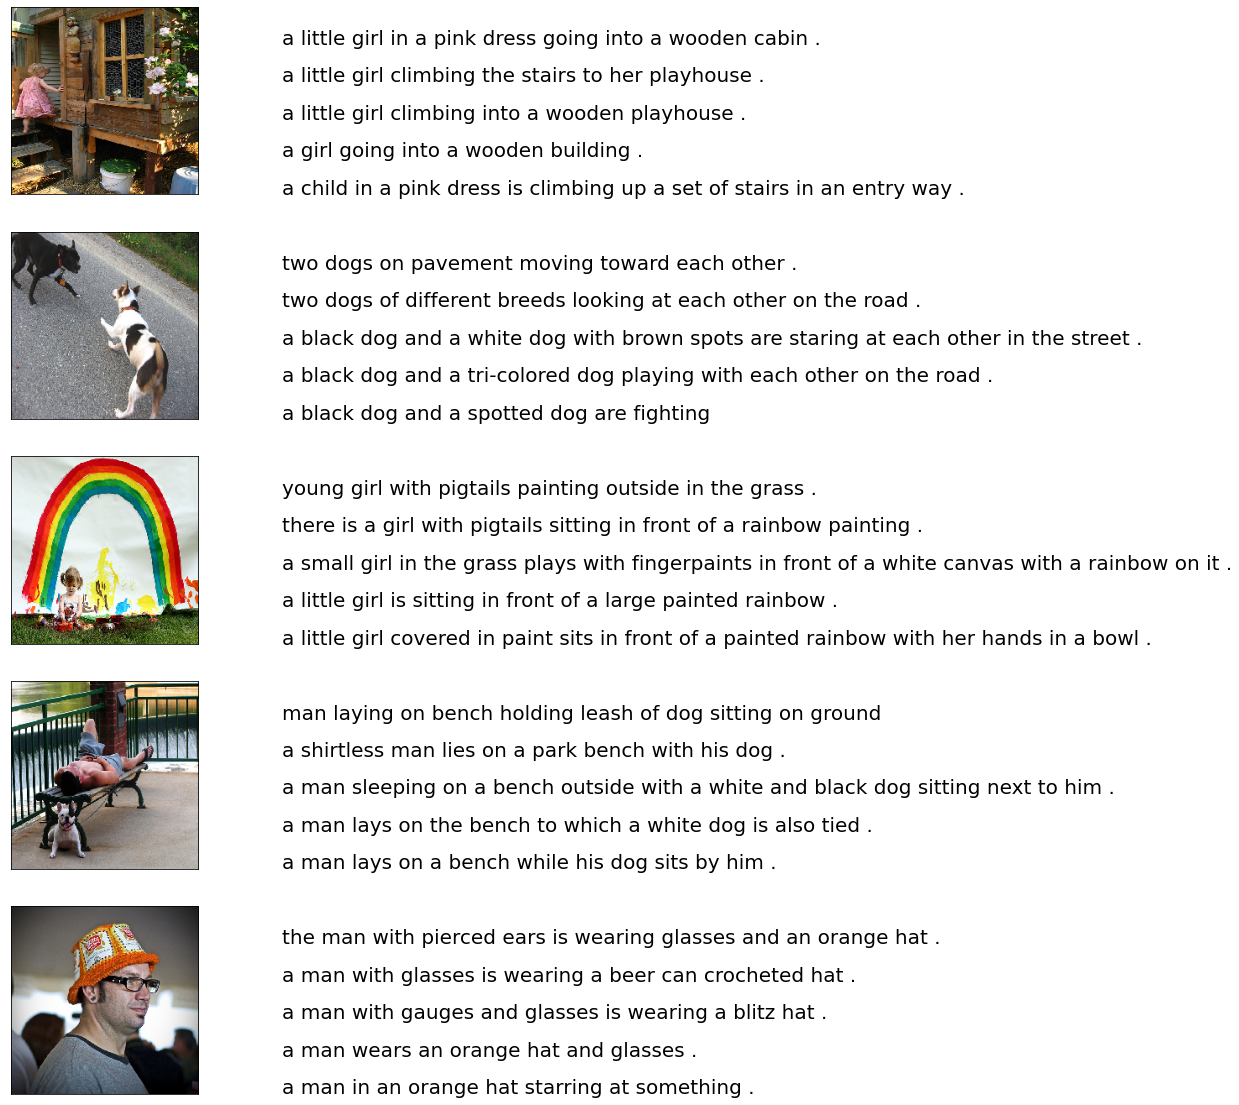

In [5]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Displaying (npic = 5) pics from the dataset
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Data Preparation

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [6]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


#### The most and least frequently appearing words

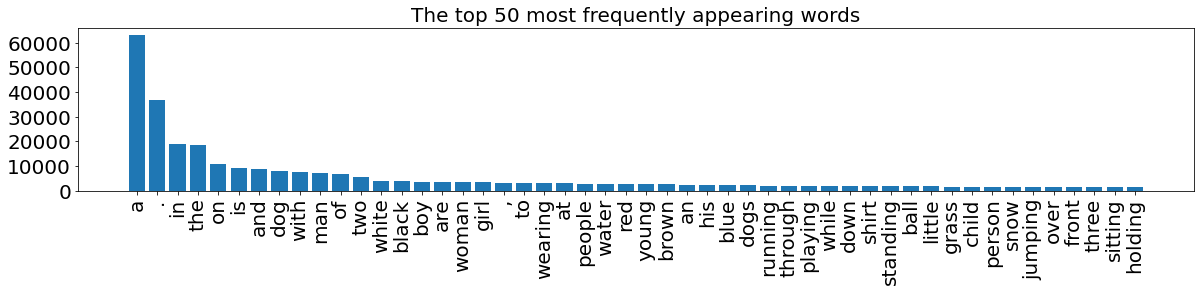

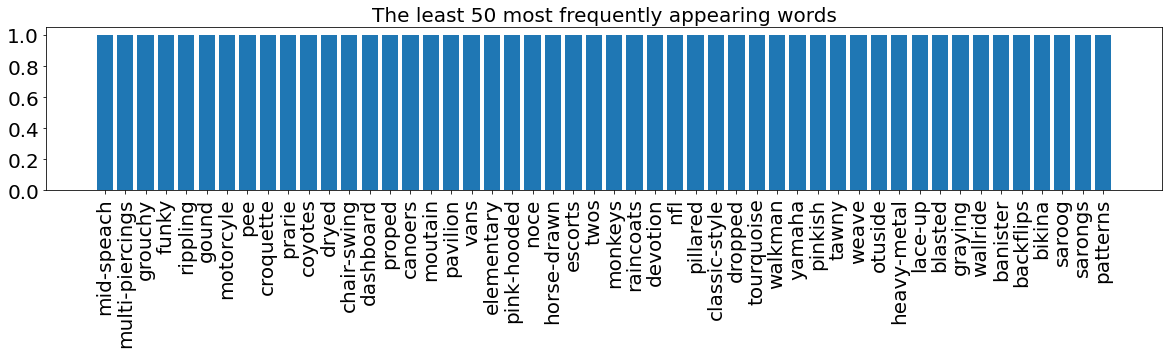

In [7]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

INFERENCE: The most common words are articles such as "a", or "the", or punctuations.

In order to clean the caption, We will create three functions that:

* remove punctuation
* remove single character
* remove numeric characters

###### Cleaning example string using these 3 functions

In [8]:
import string
text_original = "I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?

Remove punctuations..
I scored 21 in NLP but Akshat topped I have python v38 Its 420 pm Could you give us 20 on 20

Remove a single character word..
 scored 21 in NLP but Akshat topped have python v38 Its 420 pm Could you give us 20 on 20

Remove words with numeric values..
    scored     : True
    21         : False
    in         : True
    NLP        : True
    but        : True
    Akshat     : True
    topped     : True
    have       : True
    python     : True
    v38        : False
    Its        : True
    420        : False
    pm         : True
    Could      : True
    you        : True
    give       : True
    us         : True
    20         : False
    on         : True
    20         : False
 scored in NLP but Akshat topped have python Its pm Could you give us on


### Cleaning all captions in dataset

Using the 3 functions, we will clean all captions

In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning our vocabulary size is significantly reduced by around 200 words.

#### Now, after cleaning the caption list of 50 most occurring and least occurring words

Vocabulary Size: 8763


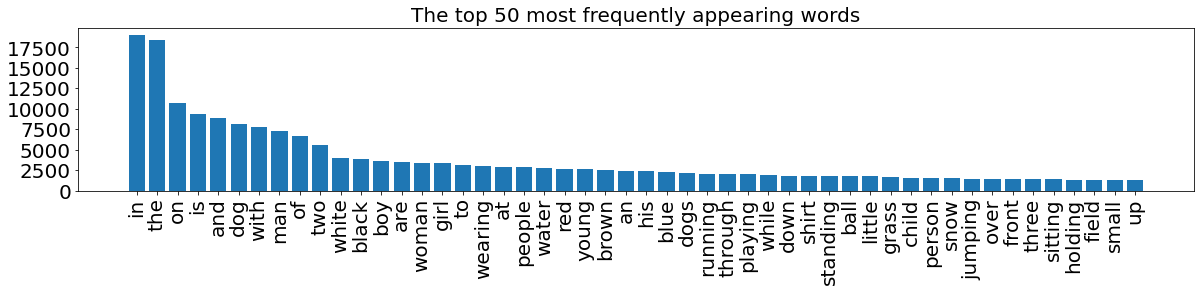

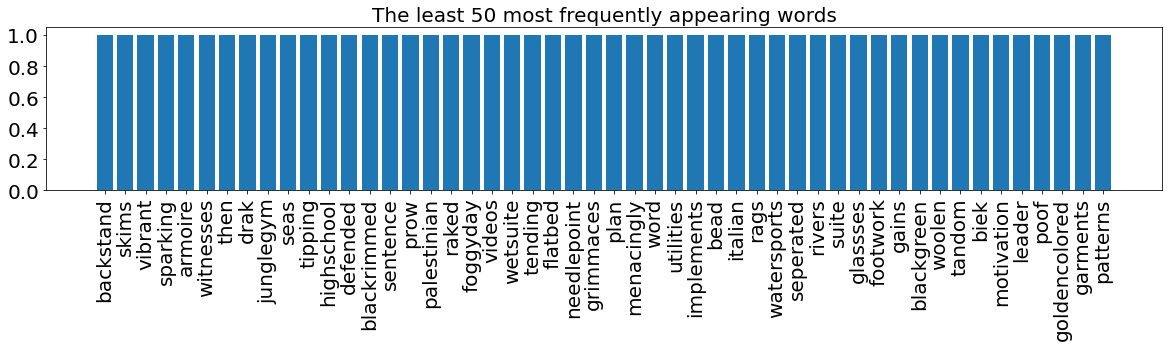

In [10]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

### Adding Start and End sequence tokens in every caption

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

## Image Preparation for the VGG16 Model

We will be using pre-trained network VGG16. This model takes input image of size (224, 224, 3).

We choose this model because it achieves 92.7% (top-5 test accuracy) in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

#### Double-click __here__ for the source of Model.

<!--
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
-->

In [12]:
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
## load the locally saved weights 
modelvgg.load_weights("C:/Users/aksha/Desktop/image-caption/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

__VGG16 is developed to classify images into 1,000 different classes. As we are not using VGG16 for the sake of the classification but we just need it for extracting features, we will remove the last layer from the network.__

In [13]:
modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Transforming images to features using model

In [14]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

In [15]:
images['1000268201_693b08cb0e.jpg']

array([2.5076473, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [16]:
len(images)

8091

### Linking the text and image data

In [17]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [18]:
# 4096 features for all 8091 images

dimages.shape

(8091, 4096)

In [19]:
# List of caption for each image

dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

## Tokenizer

Changing character vector to integer vector/tokens

In [20]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 4476


In [21]:
# dtexts contains dcaptions but in token/integer form

dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

### Spliting the dataset in training and testing

In [22]:
# We will split the dataset in ratio 6:2:2 (train:valid:test)

prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [23]:
# We need maxlen because keras layer takes input of all the sequences of same length.
# Hence to do the padding we need maximum length in caption

maxlen = np.max([len(text) for text in dtexts])

In [24]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [59]:
# First caption (dt_train[0]) represented in Xtext_train

Xtext_train[:14]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

In [26]:
# For each word (49631 words excluding start token) there is a image associated with it
# Image will be same for all words in a caption (i.e. if caption length is 14 Ximage_train[0] = Ximage_train[13])

Ximage_train.shape

(49631, 4096)

In [27]:
# Words one-hot encoding (vocab-size = 4476)

ytext_train.shape

(49631, 4476)

## Model

In [28]:
Ximage_train.shape[1]

4096

In [29]:
from tensorflow.keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = layers.Input(shape=(maxlen,))
### The embedding layer in Keras can be used when we want to create the embeddings to embed higher dimensional data into lower dimensional vector space.
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
__________________________________________________________________________________

__We are giving our model an image and a word (Ximage_train & Xtext_train respectively) and we want it to predict the next word for it which is our target ytext_train__

In [64]:
# Example: Here we are giving one image and a start-word and we want to predict next word.
# The next word is in our target which is 75.

print(Ximage_train[0])
print(Xtext_train[0])
print(ytext_train[0][75])

[2.9835706  0.         0.22122395 ... 0.         0.         0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1.0


In [31]:
# fit model
start = time.time()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
    
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
776/776 - 220s - loss: 5.3344 - val_loss: 4.7971
Epoch 2/5
776/776 - 157s - loss: 4.3576 - val_loss: 4.5122
Epoch 3/5
776/776 - 126s - loss: 3.8868 - val_loss: 4.4278
Epoch 4/5
776/776 - 110s - loss: 3.5668 - val_loss: 4.4772
Epoch 5/5
776/776 - 105s - loss: 3.2963 - val_loss: 4.5820
TIME TOOK 12.12MIN


In [32]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4476)


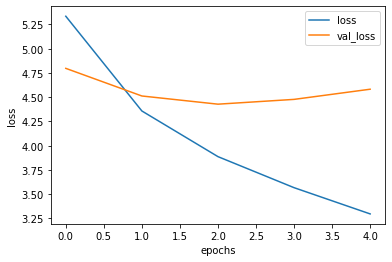

In [33]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

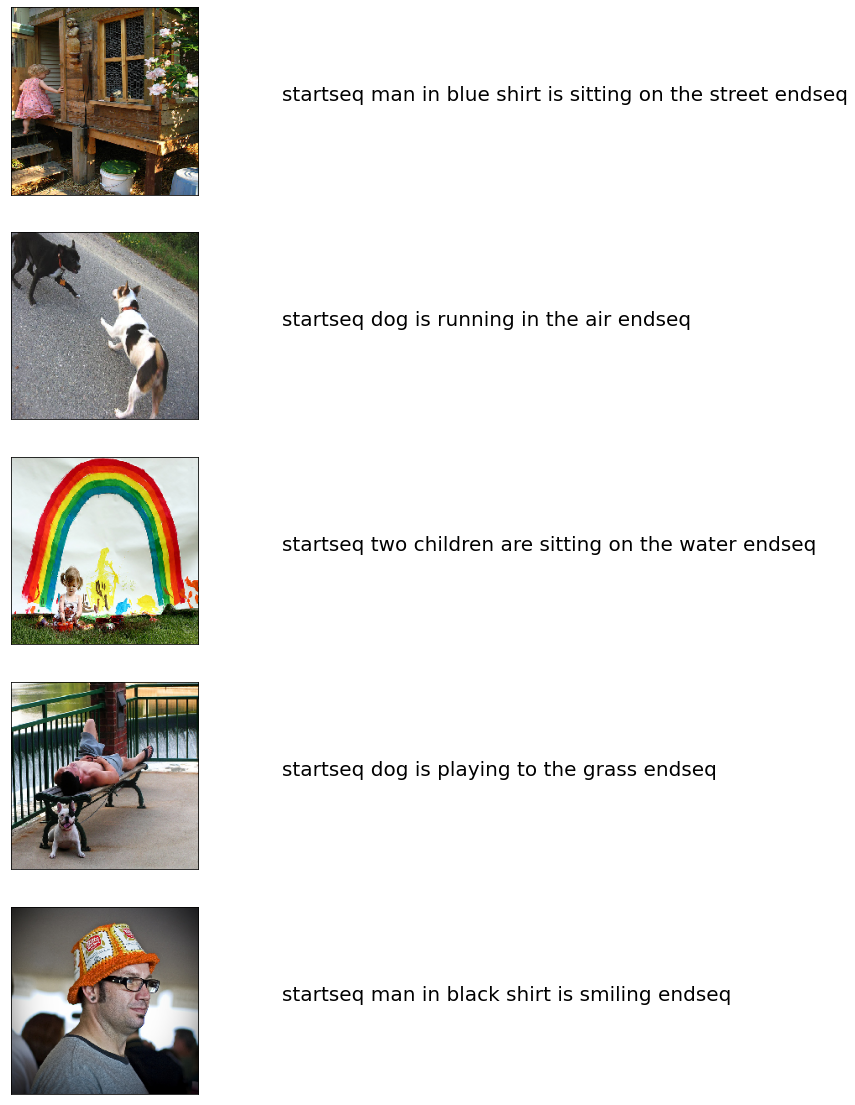

In [34]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [35]:
images['1000268201_693b08cb0e.jpg'].shape

(4096,)

## BLEU SCORE

In [48]:
start = time.time()

from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
end = time.time()
print((start-end)/60)

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
-10.603460971514384


In [50]:
pred_good

[(0.6803749333171202,
  '1032460886_4a598ed535.jpg',
  ['man', 'is', 'standing', 'in', 'front', 'of', 'skyscraper'],
  ['man', 'is', 'standing', 'in', 'front', 'of', 'the', 'street']),
 (0.6004287712485592,
  '1330645772_24f831ff8f.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'field']),
 (1.0,
  '1361420539_e9599c60ae.jpg',
  ['black', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black', 'dog', 'is', 'running', 'in', 'the', 'grass'])]

In [51]:
pred_bad[:2]

[(7.176794039009363e-232,
  '1000268201_693b08cb0e.jpg',
  ['child',
   'in',
   'pink',
   'dress',
   'is',
   'climbing',
   'up',
   'set',
   'of',
   'stairs',
   'in',
   'an',
   'entry',
   'way'],
  ['man', 'in', 'blue', 'shirt', 'is', 'sitting', 'on', 'the', 'street']),
 (9.853445011990208e-232,
  '1001773457_577c3a7d70.jpg',
  ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
  ['dog', 'is', 'running', 'in', 'the', 'air'])]

In [52]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.008


Bad Caption


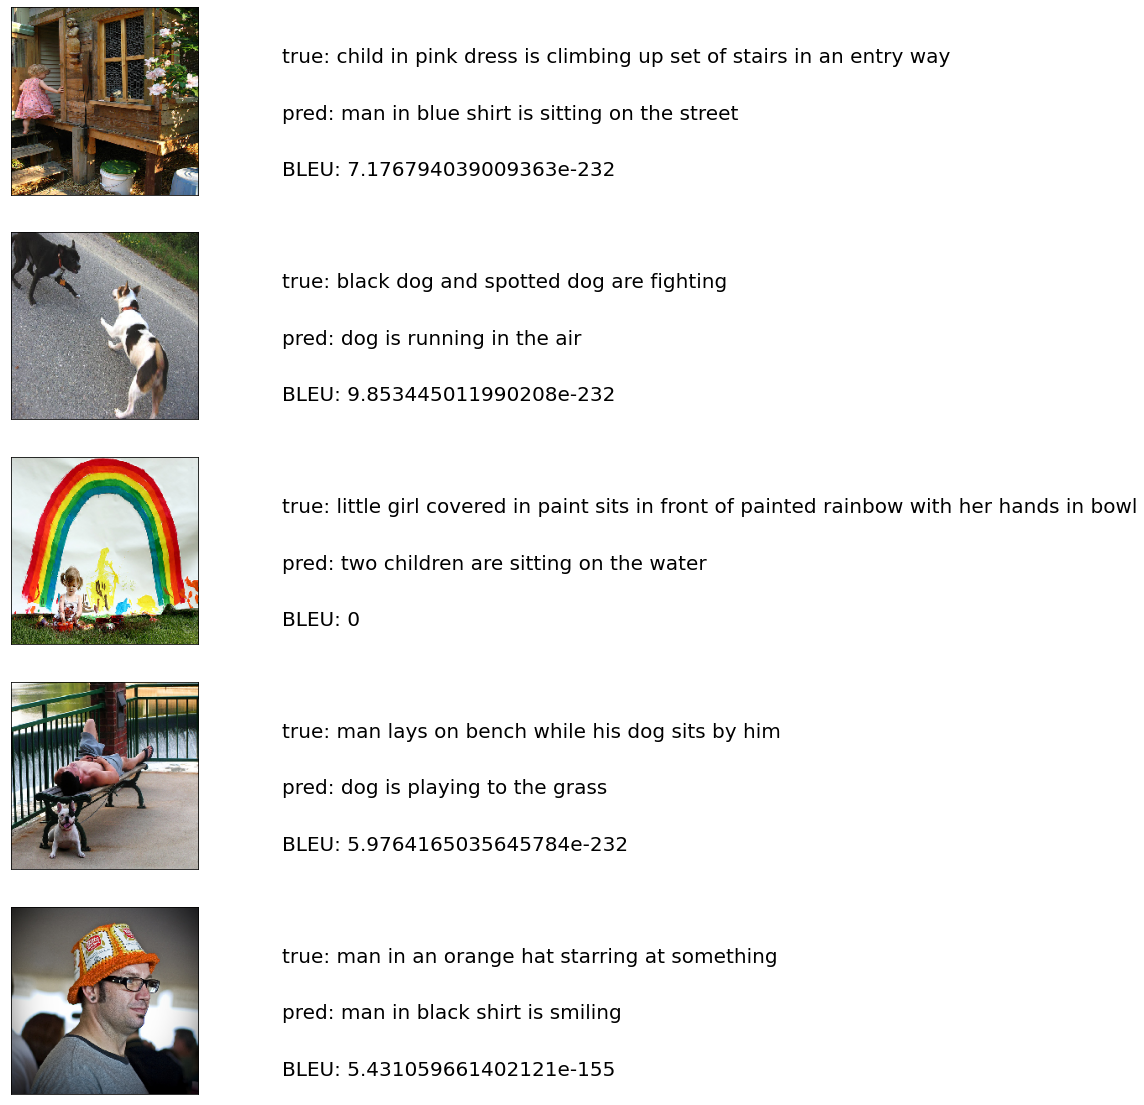

Good Caption


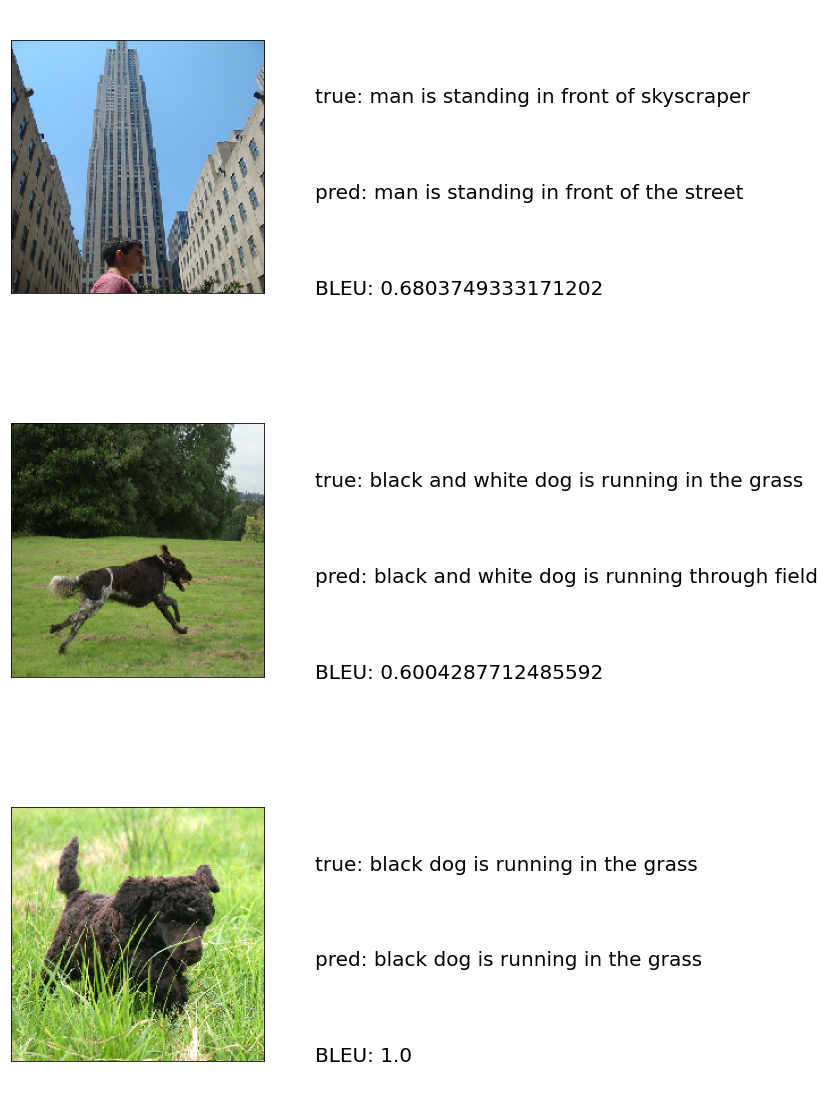

In [53]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

## GUI

In [54]:
# Importing libraries

import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog

In [55]:
import os

os.chdir('C:\\Users\\aksha\\desktop\\image-caption')
os.getcwd()

'C:\\Users\\aksha\\desktop\\image-caption'

In [56]:
def upload_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    basewidth = 300
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1]).upper()).pack()
    panel_image = tk.Label(frame, image=img).pack()
    
def caption():
    
    original = Image.open(image_data)
    original = original.resize((224, 224), Image.ANTIALIAS)
    numpy_image = img_to_array(original)
    nimage = preprocess_input(numpy_image)
    
    feature = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    caption = predict_caption(feature)
    table = tk.Label(frame, text="Caption: " + caption[9:-7], font=("Helvetica", 12)).pack()

In [67]:
root = tk.Tk()
root.title('IMAGE CAPTION GENERATOR')
root.iconbitmap('class.ico')
root.resizable(False, False)
tit = tk.Label(root, text="IMAGE CAPTION GENERATOR", padx=25, pady=6, font=("", 12)).pack()
canvas = tk.Canvas(root, height=550, width=600, bg='#D1EDf2')
canvas.pack()
frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.8, relheight=0.8, relx=0.1, rely=0.1)
chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=upload_img, activebackground="#add8e6")
chose_image.pack(side=tk.LEFT)

caption_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=caption, activebackground="#add8e6")
caption_image.pack(side=tk.RIGHT)
root.mainloop()